# Correlation Between Content Engagement & Sales Performance 
Author: Lavinia Wang<br>
@Showpad

This project aims to find out how content engagement during a sales cycle correlates to win rate, deal size, and/or sales cycle length.

In [1]:
# Import modules
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
os.chdir("/Users/liyan.wang/Desktop/Correlation_Content_Engagement_Sales Performance")

In [3]:
# Load files to pandas dataframe
sfdc_share = pd.read_csv("report1544695853372.csv", header=1)
sfdc_opp = pd.read_csv("opportunities.csv", header=0)
sfdc_stage = pd.read_csv("opportunity-history-export.csv", header=0)
mkt_lib = pd.read_csv("library-marketing-content showpad-export-20190709.csv", header=0)
user_act = pd.read_csv("user-activity export.csv", header=0)
top_mkt = pd.read_csv("top-content-marketing.csv", header=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def sfdc_data_cleaning(df1, df2, df3):
    sfdc_share_copy = df1[:-7]
    sfdc_share_clean = pd.DataFrame(sfdc_share_copy[['content_name', 'opportunity_id', 'time_spent', 'view_time', 'days_to_close']]).drop_duplicates(keep='first').sort_values(by=['content_name']).reset_index(drop=True)
    
    sfdc_opp_copy = df2[:-7].drop(['opportunity_type','added_arr_converted_currency','days_from_sqo_to_won',
                                   'owner_name', 'owner_role', 'account_name', 'opportunity_stage'], axis=1)
    
    
    sfdc_stage_copy = df3[:-5].drop(['Stage Change', 'Opportunity Name', 'Owner', 'From Stage', 'Amount Currency', 'Amount', 
                                     'Probability (%)',  'Last Modified',  'Last Modified By'], axis=1)
    
    return sfdc_share_clean, sfdc_opp_copy, sfdc_stage_copy

In [5]:
def engagement_data_cleaning(df1, df2, df3):
    # library marketing content export
    mkt_lib_file = pd.DataFrame(df1.groupby(by='asset name').sum())
    lifetime_engagement = mkt_lib_file[['(page)views', 'likes']]

    # user activity export
    user_act_copy = df2.dropna(subset = ['File Name'])
    recent_engagement = pd.DataFrame(user_act_copy.groupby(by='File Name').agg('sum'))

    # top content marketing export
    top_mkt_file = pd.DataFrame(df3.groupby(by='Display name').sum())
    top_mkt_copy = top_mkt_file[['In-app number of views', 'In-app avg daily view duration (secs)', 
                                 'In-app viewers', 'In-app avg view duration (secs)', 'Recipient number of views',
                                 'Recipient avg daily view duration (secs)', 'Recipient viewers',
                                 'Recipient avg view duration (secs)', 'Shares', 'Social shares']]

    return recent_engagement, lifetime_engagement, top_mkt_copy

def merge_engagement(df1, df2, df3): 
    recent_engagement, lifetime_engagement, top_mkt_copy = engagement_data_cleaning(df1, df2, df3)
    table = pd.concat([recent_engagement, lifetime_engagement, top_mkt_copy], axis=1).reset_index()

    return table

In [6]:
merged_engagement_df = merge_engagement(mkt_lib, user_act, top_mkt).rename(columns={'index': 'content_name','Number of File Views': 'views_recent', 'Number of File Downloads': 'downloads_recent', '(page)views': 'views_lifetime', 'likes': 'likes_lifetime'})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
sfdc_clean, opp_clean, stage_clean = sfdc_data_cleaning(sfdc_share, sfdc_opp, sfdc_stage)

In [8]:
opp_combined = pd.merge(opp_clean, stage_clean, how='inner', left_on='opportunity_id', right_on='Opportunity ID').drop('Opportunity ID', axis=1)
#opp_combined

In [9]:
sfdc_combined = pd.merge(sfdc_clean, opp_combined, how='inner', on='opportunity_id')
#sfdc_combined

In [10]:
sfdc_combined.shape

(21091, 14)

In [11]:
sfdc_combined.describe(include="all")

,content_name,opportunity_id,time_spent,view_time,days_to_close,opportunity_name,added_arr_converted,opportunity_close_date,stage_duration,age,opportunity_created_date,Stage Duration,Close Date,To Stage
count,21091,21091,1.422600e+04,14226,21091.000000,21091,19755.000000,21091,21091.000000,21091.000000,21091,21091.000000,21091,21091
unique,553,420,NaN,1887,NaN,419,NaN,240,NaN,NaN,274,NaN,372,18
top,Showpad Overview Deck.pdf,0065700000thUKe,NaN,11/2/2018 12:52 AM,NaN,New - De Meeuw ESS +5,NaN,1/18/2019,NaN,NaN,2/15/2018,NaN,12/31/2018,Lost
freq,1649,764,NaN,56,NaN,764,NaN,1014,NaN,NaN,798,NaN,1653,4678
mean,NaN,NaN,2.152470e+03,NaN,194.394813,NaN,43044.841548,NaN,154.621734,190.209853,NaN,46.255844,NaN,NaN
std,NaN,NaN,5.414999e+04,NaN,153.561714,NaN,82775.845656,NaN,159.363639,149.692556,NaN,77.746946,NaN,NaN
min,NaN,NaN,0.000000e+00,NaN,-176.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,4.000000e+00,NaN,98.000000,NaN,12362.500000,NaN,36.000000,86.000000,NaN,0.000000,NaN,NaN
50%,NaN,NaN,9.000000e+00,NaN,166.000000,NaN,21160.000000,NaN,80.000000,157.000000,NaN,13.000000,NaN,NaN
75%,NaN,NaN,2.500000e+01,NaN,255.000000,NaN,37600.000000,NaN,266.000000,246.500000,NaN,56.000000,NaN,NaN


In [12]:
#sfdc_combined.to_csv("merged_sfdc.csv", index=False)

### Insights from invoiced opportunities

In [13]:
invoiced_opp = sfdc_combined.loc[sfdc_combined['To Stage'] == 'Invoiced'].reset_index(drop=True)
#invoiced_opp

In [14]:
invoiced_opp.describe(include="all")

,content_name,opportunity_id,time_spent,view_time,days_to_close,opportunity_name,added_arr_converted,opportunity_close_date,stage_duration,age,opportunity_created_date,Stage Duration,Close Date,To Stage
count,547,547,421.000000,421,547.000000,547,547.000000,547,547.000000,547.000000,547,547.000000,547,547
unique,98,31,NaN,245,NaN,31,NaN,18,NaN,NaN,25,NaN,19,1
top,Showpad for Intuit (5).pdf,0065700000wWrua,NaN,11/2/2018 12:52 AM,NaN,New - Caldic ULT +80 (POT 500),NaN,1/18/2019,NaN,NaN,9/19/2018,NaN,1/31/2019,Invoiced
freq,50,74,NaN,8,NaN,74,NaN,133,NaN,NaN,101,NaN,148,547
mean,NaN,NaN,516.836105,NaN,209.389397,NaN,82041.967495,NaN,60.853748,188.305302,NaN,1.729433,NaN,NaN
std,NaN,NaN,4813.202017,NaN,209.313373,NaN,101568.252713,NaN,53.062378,209.012145,NaN,2.875295,NaN,NaN
min,NaN,NaN,2.000000,NaN,24.000000,NaN,0.000000,NaN,0.000000,24.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,4.000000,NaN,103.000000,NaN,21160.000000,NaN,17.000000,86.000000,NaN,0.000000,NaN,NaN
50%,NaN,NaN,10.000000,NaN,147.000000,NaN,79902.030000,NaN,65.000000,141.000000,NaN,0.000000,NaN,NaN
75%,NaN,NaN,39.000000,NaN,226.000000,NaN,83375.000000,NaN,99.000000,191.000000,NaN,2.000000,NaN,NaN


In [21]:
a = invoiced_opp[['content_name', 'opportunity_id', 'opportunity_name', 'time_spent', 'opportunity_created_date','opportunity_close_date','added_arr_converted','view_time', 'days_to_close']].groupby(by=['content_name','opportunity_id', 'opportunity_name']).agg({'time_spent':'sum', 'view_time': 'count','opportunity_created_date':'max','opportunity_close_date':'max','added_arr_converted':'max', 'days_to_close':'max'})

In [23]:
invoiced_df = pd.DataFrame(a).reset_index().rename(columns={"time_spent": "total_time_spent", "view_time": "#_of_view"})
#invoiced_df

In [24]:
#use invoiced id to find out 
#how many stages inviced opporunities went through

invoiced_id = np.array(invoiced_opp[['opportunity_id']].drop_duplicates(keep='first'))
invoiced_id = [invoiced_id[i][0] for i in range(len(invoiced_id))]
invoiced_copy = sfdc_combined.loc[sfdc_combined['opportunity_id'].isin(invoiced_id)].reset_index(drop=True)

#invoiced_copy

In [25]:
#count of stages
invoiced_stages = invoiced_copy[['content_name','opportunity_id', 'To Stage']].drop_duplicates(keep='first').groupby(by=['content_name','opportunity_id']).count()

invoiced_stages_col = pd.DataFrame(invoiced_stages).reset_index()
invoiced_df['#_of_stages'] = invoiced_stages_col['To Stage']

#invoiced_df

In [26]:
merged_invoiced = pd.merge(merged_engagement_df, invoiced_df, how='inner', on='content_name')
#merged_invoiced

In [27]:
#how many contents used in one opportunity
invoiced_opp_content_used = merged_invoiced[['content_name', 'opportunity_id']].groupby(by='opportunity_id').count()
#how many opportunites used the same content
invoiced_content_opp_used = merged_invoiced[['content_name', 'opportunity_id']].groupby(by='content_name').count()

invoiced_opp_content_used_df = pd.DataFrame(invoiced_opp_content_used).reset_index()
invoiced_content_opp_used_df = pd.DataFrame(invoiced_content_opp_used).reset_index()

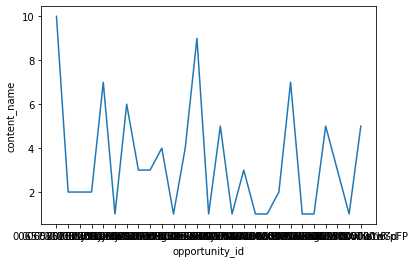

In [28]:
sns.lineplot(x='opportunity_id', y='content_name', data=invoiced_opp_content_used_df)

In [141]:
import plotly.offline as pyo
pyo.plot([{
    "x": invoiced_opp_content_used_df.opportunity_id,
    "y": invoiced_opp_content_used_df.content_name
}])

'temp-plot.html'

In [29]:
invoiced_opp_content_used.describe()

,content_name
count,27.000000
mean,3.370370
std,2.603964
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,10.000000


In [30]:
top_content_invoiced = invoiced_opp_content_used_df.loc[invoiced_opp_content_used_df['content_name'] > 8]
top_content_invoiced

,opportunity_id,content_name
0,0065700000syYvj,10
12,0065700000w7NkA,9


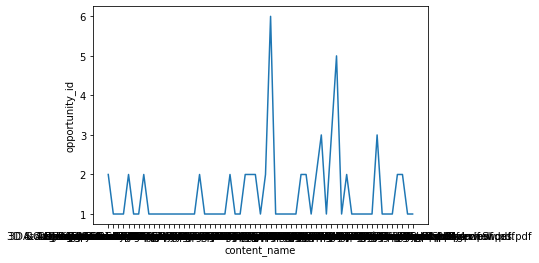

In [31]:
sns.lineplot(x='content_name', y='opportunity_id', data=invoiced_content_opp_used_df)

In [142]:
pyo.plot([{
    "x": invoiced_content_opp_used_df.content_name,
    "y": invoiced_content_opp_used_df.opportunity_id
}])

'temp-plot.html'

In [32]:
invoiced_content_opp_used.describe()

,opportunity_id
count,61.000000
mean,1.491803
std,0.942036
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,6.000000


In [33]:
common_content_invoiced = invoiced_content_opp_used_df.loc[invoiced_content_opp_used_df['opportunity_id'] > 4]
common_content_invoiced

,content_name,opportunity_id
32,Salesforce Integration One Pager.pdf,6
45,Showpad Platform Discovery & Vision Deck.pdf,5


In [139]:
invoiced_content_opp_used_df.to_csv("common_content_invoiced.csv", index=False)

In [35]:
#reorder df columns
merged_invoiced = merged_invoiced[['content_name', 'opportunity_id', 'opportunity_name', 'views_recent', 'downloads_recent', 'views_lifetime',
       'likes_lifetime', 'In-app number of views',
       'In-app avg daily view duration (secs)', 'In-app viewers',
       'In-app avg view duration (secs)', 'Recipient number of views',
       'Recipient avg daily view duration (secs)', 'Recipient viewers',
       'Recipient avg view duration (secs)', 'Shares', 'Social shares','total_time_spent', '#_of_view',
       'opportunity_created_date', 'opportunity_close_date',
       'added_arr_converted', '#_of_stages', 'days_to_close']]

In [36]:
merged_invoiced.describe(include="all")

,content_name,opportunity_id,opportunity_name,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,...,Recipient avg view duration (secs),Shares,Social shares,total_time_spent,#_of_view,opportunity_created_date,opportunity_close_date,added_arr_converted,#_of_stages,days_to_close
count,91,91,91,73.000000,73.000000,87.000000,87.00000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,91.000000,91.000000,91,91,91.000000,91.000000,91.000000
unique,61,27,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21,16,NaN,NaN,NaN
top,Salesforce Integration One Pager.pdf,0065700000syYvj,New - The Cookware Company PLUS +25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8/9/2018,12/31/2018,NaN,NaN,NaN
freq,6,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14,16,NaN,NaN,NaN
mean,NaN,NaN,NaN,20.835616,1.205479,3837.114943,0.37931,20.655172,58.298851,9.827586,...,54.666667,15.632184,7.563218,240.109890,2.417582,NaN,NaN,98760.520659,5.802198,156.362637
std,NaN,NaN,NaN,35.046403,3.063943,6695.617290,0.86591,20.933354,45.611890,8.690020,...,91.991237,30.026002,16.939496,981.827225,4.376873,NaN,NaN,150285.782082,1.990085,98.200307
min,NaN,NaN,NaN,0.000000,0.000000,43.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,3.000000,24.000000
25%,NaN,NaN,NaN,4.000000,0.000000,567.000000,0.00000,5.000000,17.000000,3.000000,...,8.000000,2.000000,1.000000,0.000000,0.000000,NaN,NaN,22500.000000,4.000000,94.500000
50%,NaN,NaN,NaN,8.000000,0.000000,1200.000000,0.00000,13.000000,56.000000,6.000000,...,32.000000,6.000000,2.000000,8.000000,1.000000,NaN,NaN,63176.400000,6.000000,144.000000
75%,NaN,NaN,NaN,20.000000,2.000000,3787.000000,0.00000,32.000000,80.500000,15.000000,...,63.000000,17.500000,4.500000,35.500000,2.000000,NaN,NaN,115639.000000,8.000000,187.500000


In [37]:
merged_invoiced.describe()

,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,In-app avg view duration (secs),Recipient number of views,Recipient avg daily view duration (secs),Recipient viewers,Recipient avg view duration (secs),Shares,Social shares,total_time_spent,#_of_view,added_arr_converted,#_of_stages,days_to_close
count,73.000000,73.000000,87.000000,87.00000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,20.835616,1.205479,3837.114943,0.37931,20.655172,58.298851,9.827586,24.804598,24.413793,191.574713,7.862069,54.666667,15.632184,7.563218,240.109890,2.417582,98760.520659,5.802198,156.362637
std,35.046403,3.063943,6695.617290,0.86591,20.933354,45.611890,8.690020,17.330467,38.081477,308.707645,11.817579,91.991237,30.026002,16.939496,981.827225,4.376873,150285.782082,1.990085,98.200307
min,0.000000,0.000000,43.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,24.000000
25%,4.000000,0.000000,567.000000,0.00000,5.000000,17.000000,3.000000,14.000000,1.000000,19.500000,1.000000,8.000000,2.000000,1.000000,0.000000,0.000000,22500.000000,4.000000,94.500000
50%,8.000000,0.000000,1200.000000,0.00000,13.000000,56.000000,6.000000,21.000000,8.000000,61.000000,3.000000,32.000000,6.000000,2.000000,8.000000,1.000000,63176.400000,6.000000,144.000000
75%,20.000000,2.000000,3787.000000,0.00000,32.000000,80.500000,15.000000,31.500000,24.000000,315.000000,9.000000,63.000000,17.500000,4.500000,35.500000,2.000000,115639.000000,8.000000,187.500000
max,155.000000,23.000000,24783.000000,4.00000,84.000000,253.000000,36.000000,78.000000,196.000000,1864.000000,68.000000,621.000000,216.000000,73.000000,8206.000000,26.000000,965057.000000,9.000000,367.000000


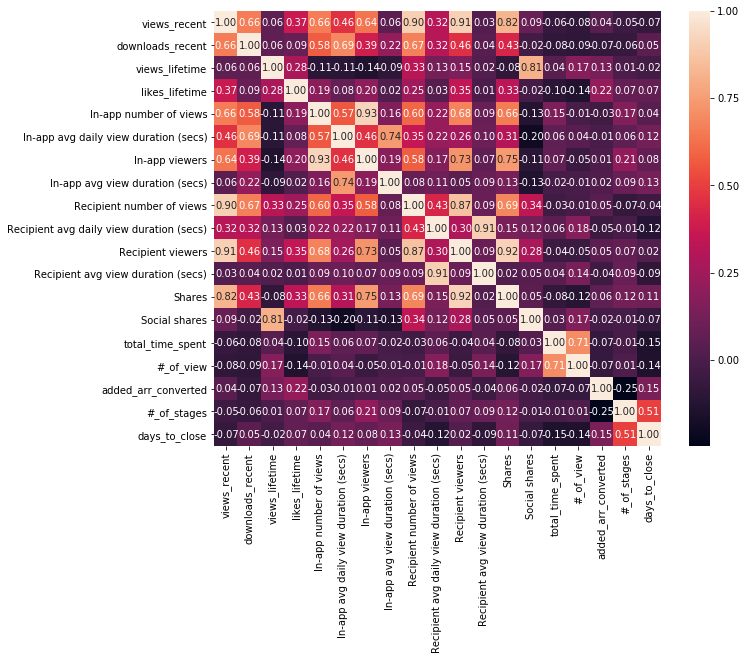

In [38]:
plt.figure(figsize = (10, 8))
sns.heatmap(merged_invoiced.corr(), annot=True, fmt='.2f')

In [39]:
#add opportunity status column
merged_invoiced['status'] = 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Insights from lost opportunities

In [40]:
lost_opp = sfdc_combined.loc[sfdc_combined['To Stage'] == 'Lost'].reset_index(drop=True)
#lost_opp

In [41]:
lost_opp.describe(include="all")

,content_name,opportunity_id,time_spent,view_time,days_to_close,opportunity_name,added_arr_converted,opportunity_close_date,stage_duration,age,opportunity_created_date,Stage Duration,Close Date,To Stage
count,4678,4678,2.999000e+03,2999,4678.000000,4678,4049.000000,4678,4678.000000,4678.000000,4678,4678.000000,4678,4678
unique,510,380,NaN,1618,NaN,379,NaN,229,NaN,NaN,257,NaN,183,1
top,Showpad Overview Deck.pdf,0065700000thUKe,NaN,6/28/2017 1:24 PM,NaN,New - De Meeuw ESS +5,NaN,3/23/2018,NaN,NaN,2/15/2018,NaN,7/31/2018,Lost
freq,418,191,NaN,11,NaN,191,NaN,205,NaN,NaN,201,NaN,279,4678
mean,NaN,NaN,1.978339e+03,NaN,170.760795,NaN,33597.994883,NaN,180.910432,173.052373,NaN,120.508764,NaN,NaN
std,NaN,NaN,5.272752e+04,NaN,129.265770,NaN,67925.873912,NaN,164.286162,122.925334,NaN,101.419834,NaN,NaN
min,NaN,NaN,0.000000e+00,NaN,-176.000000,NaN,0.000000,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,4.000000e+00,NaN,79.000000,NaN,11500.000000,NaN,51.000000,79.000000,NaN,39.000000,NaN,NaN
50%,NaN,NaN,8.000000e+00,NaN,149.000000,NaN,19320.000000,NaN,142.000000,150.000000,NaN,95.000000,NaN,NaN
75%,NaN,NaN,2.300000e+01,NaN,243.000000,NaN,34500.000000,NaN,287.000000,243.000000,NaN,170.000000,NaN,NaN


In [42]:
b = lost_opp[['content_name', 'opportunity_id', 'opportunity_name', 'time_spent', 'opportunity_created_date','opportunity_close_date','added_arr_converted','view_time', 'days_to_close']].groupby(by=['content_name','opportunity_id', 'opportunity_name']).agg({'time_spent':'sum', 'view_time': 'count','opportunity_created_date':'max','opportunity_close_date':'max','added_arr_converted':'max', 'days_to_close':'max'})

In [43]:
lost_df = pd.DataFrame(b).reset_index().rename(columns={"time_spent": "total_time_spent", "view_time": "#_of_view"})
#lost_df

In [44]:
lost_id = np.array(lost_opp[['opportunity_id']].drop_duplicates(keep='first'))
lost_id = [lost_id[i][0] for i in range(len(lost_id))]
lost_copy = sfdc_combined.loc[sfdc_combined['opportunity_id'].isin(lost_id)].reset_index(drop=True)

#lost_copy

In [45]:
#count of stages
lost_stages = lost_copy[['content_name','opportunity_id', 'To Stage']].drop_duplicates(keep='first').groupby(by=['content_name','opportunity_id']).count()

lost_stages_col = pd.DataFrame(lost_stages).reset_index()
lost_df['#_of_stages'] = lost_stages_col['To Stage']

In [46]:
merged_lost = pd.merge(merged_engagement_df, lost_df, how='inner', on='content_name')

In [47]:
#how many contents used in one opportunity
lost_opp_content_used = merged_lost[['content_name', 'opportunity_id']].groupby(by='opportunity_id').count()
#how many opportunites used the same content
lost_content_opp_used = merged_lost[['content_name', 'opportunity_id']].groupby(by='content_name').count()

lost_opp_content_used_df = pd.DataFrame(lost_opp_content_used).reset_index()
lost_content_opp_used_df = pd.DataFrame(lost_content_opp_used).reset_index()

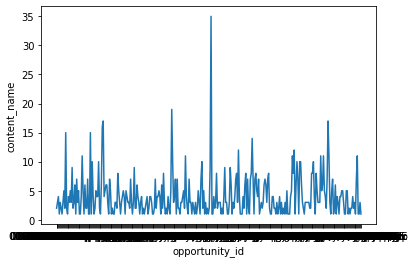

In [48]:
sns.lineplot(x='opportunity_id', y='content_name', data=lost_opp_content_used_df)

In [49]:
lost_opp_content_used.describe()

,content_name
count,334.000000
mean,4.047904
std,3.614798
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,35.000000


In [50]:
top_content_lost = lost_opp_content_used_df.loc[lost_opp_content_used_df['content_name'] > 15]
top_content_lost

,opportunity_id,content_name
50,0065700000qitNY,16
51,0065700000qiw84,17
126,0065700000rmwLY,19
169,0065700000thUKe,35
297,0065700000wWZfz,17


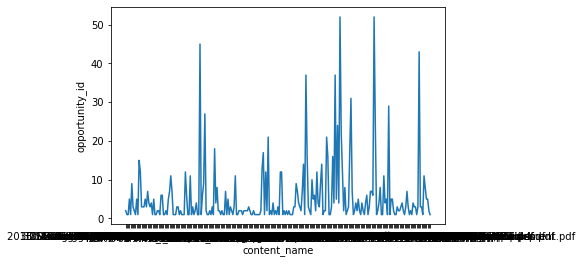

In [51]:
sns.lineplot(x='content_name', y='opportunity_id', data=lost_content_opp_used_df)

In [52]:
lost_content_opp_used.describe()

,opportunity_id
count,251.000000
mean,5.386454
std,8.107161
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,52.000000


In [137]:
common_content_lost = lost_content_opp_used_df.loc[lost_content_opp_used_df['opportunity_id'] > 20].sort_values(by='opportunity_id', ascending=False)
common_content_lost

,content_name,opportunity_id
176,Showpad Overview Deck.pdf,52
204,Showpad for Marketing One Pager.pdf,52
61,DEPRECATED_Showpad Messaging Deck.pdf,45
241,Why Showpad Video.mp4,43
148,Salesforce Integration One Pager.pdf,37
172,Showpad Experiences One Pager.pdf,37
185,Showpad ROI for Marketing Infographic.pdf,31
216,Showpad for Sales One Pager.pdf,29
65,Deployment & Time to value Value Doc.pdf,27
174,Showpad Experiences Value Video.mp4,24


In [54]:
#reorder df columns
merged_lost = merged_lost[['content_name', 'opportunity_id', 'opportunity_name', 'views_recent', 'downloads_recent', 'views_lifetime',
       'likes_lifetime', 'In-app number of views',
       'In-app avg daily view duration (secs)', 'In-app viewers',
       'In-app avg view duration (secs)', 'Recipient number of views',
       'Recipient avg daily view duration (secs)', 'Recipient viewers',
       'Recipient avg view duration (secs)', 'Shares', 'Social shares','total_time_spent', '#_of_view',
       'opportunity_created_date', 'opportunity_close_date',
       'added_arr_converted', '#_of_stages', 'days_to_close']]

In [55]:
merged_lost.describe(include="all")

,content_name,opportunity_id,opportunity_name,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,...,Recipient avg view duration (secs),Shares,Social shares,total_time_spent,#_of_view,opportunity_created_date,opportunity_close_date,added_arr_converted,#_of_stages,days_to_close
count,1352,1352,1352,936.000000,936.000000,1307.000000,1307.000000,1095.000000,1095.000000,1095.000000,...,1095.000000,1095.000000,1095.000000,1352.000000,1352.000000,1352,1352,1160.000000,1352.000000,1352.000000
unique,251,334,333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,238,206,NaN,NaN,NaN
top,Showpad Overview Deck.pdf,0065700000thUKe,New - De Meeuw ESS +5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2/15/2018,3/23/2018,NaN,NaN,NaN
freq,52,35,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37,54,NaN,NaN,NaN
mean,NaN,NaN,NaN,29.231838,1.685897,3854.465187,1.041316,26.161644,71.177169,11.716895,...,49.466667,23.446575,5.454795,249.222633,1.457840,NaN,NaN,26816.720491,3.448964,167.654586
std,NaN,NaN,NaN,48.452664,3.770368,5706.145737,1.746528,23.798944,63.365525,9.773029,...,86.481151,45.445516,10.075742,2761.440995,5.236777,NaN,NaN,33671.019147,1.169081,127.367672
min,NaN,NaN,NaN,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,2.000000,-176.000000
25%,NaN,NaN,NaN,1.000000,0.000000,671.500000,0.000000,6.000000,34.000000,3.000000,...,6.000000,2.000000,1.000000,0.000000,0.000000,NaN,NaN,12510.000000,3.000000,79.000000
50%,NaN,NaN,NaN,8.000000,0.000000,1282.000000,0.000000,17.000000,65.000000,9.000000,...,26.000000,6.000000,2.000000,0.000000,0.000000,NaN,NaN,20700.010000,3.000000,140.000000
75%,NaN,NaN,NaN,22.000000,2.000000,3934.000000,1.000000,41.000000,81.000000,20.000000,...,58.000000,19.000000,7.000000,8.000000,1.000000,NaN,NaN,34776.010000,4.000000,235.000000


In [56]:
merged_lost.describe()

,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,In-app avg view duration (secs),Recipient number of views,Recipient avg daily view duration (secs),Recipient viewers,Recipient avg view duration (secs),Shares,Social shares,total_time_spent,#_of_view,added_arr_converted,#_of_stages,days_to_close
count,936.000000,936.000000,1307.000000,1307.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1352.000000,1352.000000,1160.000000,1352.000000,1352.000000
mean,29.231838,1.685897,3854.465187,1.041316,26.161644,71.177169,11.716895,29.043836,26.092237,171.806393,10.219178,49.466667,23.446575,5.454795,249.222633,1.457840,26816.720491,3.448964,167.654586
std,48.452664,3.770368,5706.145737,1.746528,23.798944,63.365525,9.773029,40.428146,41.606185,298.742766,16.358680,86.481151,45.445516,10.075742,2761.440995,5.236777,33671.019147,1.169081,127.367672
min,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-176.000000
25%,1.000000,0.000000,671.500000,0.000000,6.000000,34.000000,3.000000,17.000000,1.000000,15.000000,1.000000,6.000000,2.000000,1.000000,0.000000,0.000000,12510.000000,3.000000,79.000000
50%,8.000000,0.000000,1282.000000,0.000000,17.000000,65.000000,9.000000,22.000000,8.000000,59.000000,3.000000,26.000000,6.000000,2.000000,0.000000,0.000000,20700.010000,3.000000,140.000000
75%,22.000000,2.000000,3934.000000,1.000000,41.000000,81.000000,20.000000,33.000000,24.000000,193.000000,10.000000,58.000000,19.000000,7.000000,8.000000,1.000000,34776.010000,4.000000,235.000000
max,155.000000,23.000000,24783.000000,7.000000,84.000000,602.000000,36.000000,602.000000,196.000000,1864.000000,68.000000,723.000000,216.000000,73.000000,74653.000000,92.000000,538000.000000,7.000000,779.000000


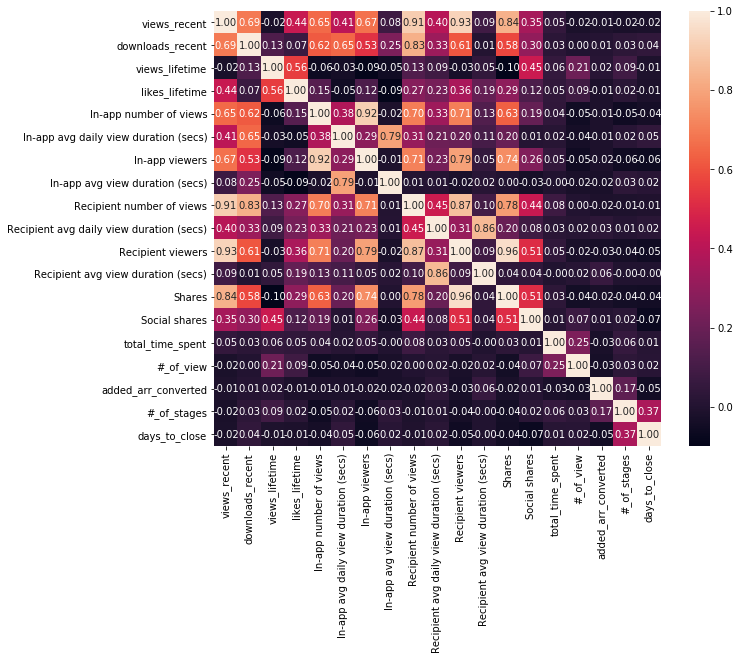

In [57]:
plt.figure(figsize = (10, 8))
sns.heatmap(merged_lost.corr(), annot=True, fmt='.2f')

In [58]:
#add opportunity status column
merged_lost['status'] = 0

From the above two correlation matrices, we can conclude:
1. One positive strong correalted cluster: views_recent, recipient number of views, recipient viewers, in-app viewers, in-app number of views, shares
2. Unique positive strong correlation in invoiced opportunities: views_lifetime & social shares, total_time_spent & #_of_view
3. Differences between invoiced and lost opportunites in in-app number of views: invoiced - shares, lost - recipient number of views

### Combine invoiced and lost for creating visualzation of comparison 

In [59]:
df = pd.concat([merged_invoiced, merged_lost], ignore_index=True)

In [60]:
df.shape

(1443, 25)

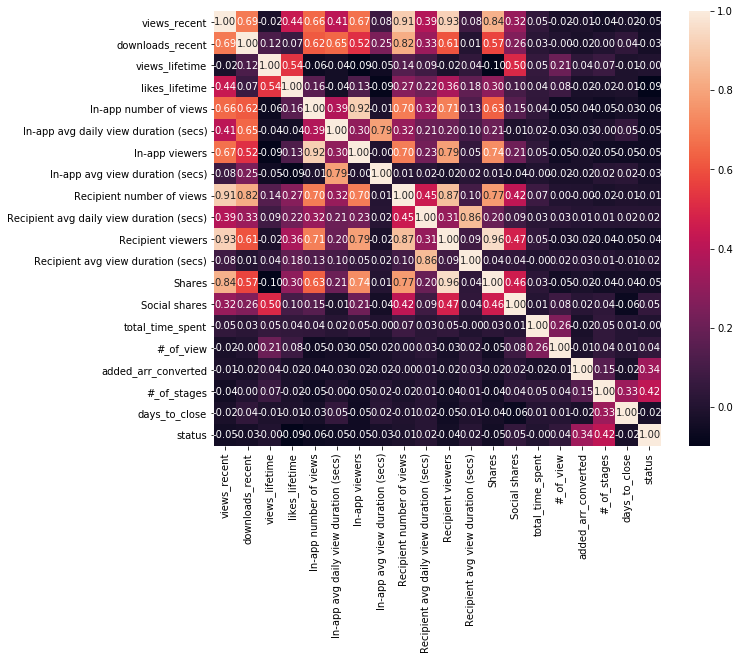

In [61]:
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [62]:
def overview(df, x_axis, y_axis):
    plt.figure(figsize = (8, 5))
    g = sns.scatterplot(x=x_axis, y=y_axis, hue='status', data=df)
    plt.show()

In [63]:
def cluster_view(df, x_axis, y_axis):
    g = sns.FacetGrid(df, col="status", hue="status")
    g.map(plt.scatter, x_axis, y_axis, alpha=.7)
    g.add_legend()

- <b>Views recent/Views lifetime/Shares vs total time spent</b>

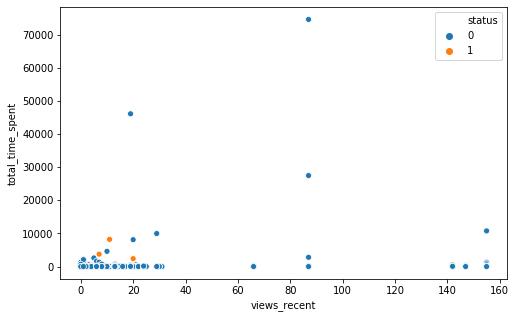

In [64]:
plot = overview(df, 'views_recent', 'total_time_spent')

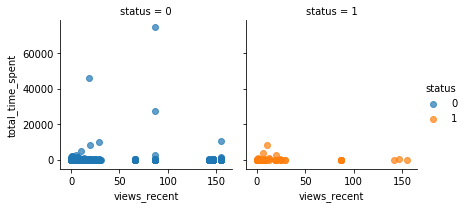

In [65]:
plot = cluster_view(df, 'views_recent', 'total_time_spent')

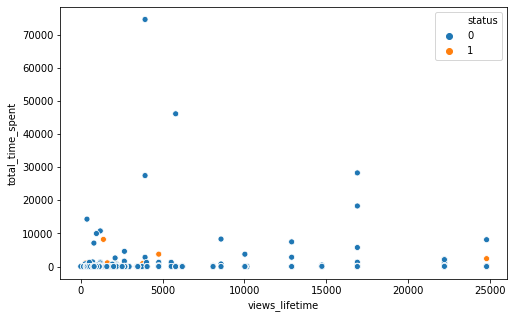

In [66]:
plot = overview(df, 'views_lifetime', 'total_time_spent')

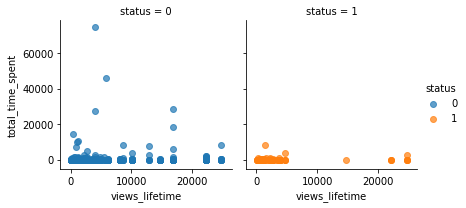

In [67]:
plot = cluster_view(df, 'views_lifetime', 'total_time_spent')

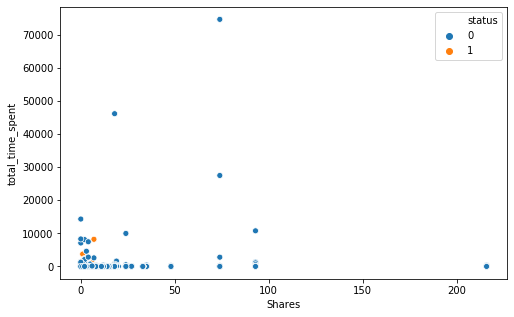

In [68]:
plot = overview(df, 'Shares', 'total_time_spent')

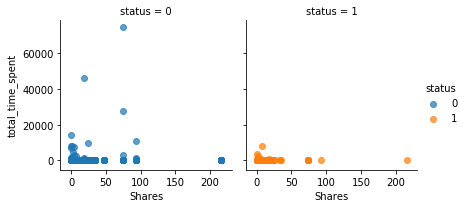

In [69]:
plot = cluster_view(df, 'Shares', 'total_time_spent')

<i>Find out those assets have high total_time_spent but lost opportunity.</i>

In [70]:
insight1 = df.loc[df['total_time_spent'] > 20000]
insight1

,content_name,opportunity_id,opportunity_name,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,...,Shares,Social shares,total_time_spent,#_of_view,opportunity_created_date,opportunity_close_date,added_arr_converted,#_of_stages,days_to_close,status
332,DEPRECATED_Showpad Messaging Deck.pdf,0065700000syM4s,Connexall- New +50 ESS,NaN,NaN,16894.0,7.0,NaN,NaN,NaN,...,NaN,NaN,28291.0,35,1/9/2018,9/25/2018,13028.77,5,259.0,0
686,Salesforce Integration One Pager.pdf,0065700000rmd0G,New - WYG Group,87.0,2.0,3934.0,1.0,53.0,81.0,26.0,...,74.0,4.0,27485.0,1,7/18/2017,3/23/2018,11500.00,3,248.0,0
709,Salesforce Integration One Pager.pdf,0065700000wWjzz,New - Tangoe - Platform,87.0,2.0,3934.0,1.0,53.0,81.0,26.0,...,74.0,4.0,74653.0,12,9/14/2018,1/23/2019,25000.00,6,131.0,0
907,Showpad Experiences Overview Deck.pdf,0065700000q6Qtr,Honeywell Building Solutions +202ENT,19.0,8.0,5802.0,0.0,51.0,137.0,20.0,...,18.0,5.0,46149.0,32,2/14/2017,11/27/2017,1389.98,4,286.0,0


- <b>Views recent/Views lifetime/Shares vs # of view</b>

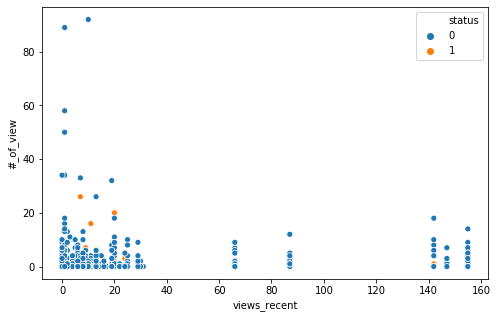

In [71]:
plot = overview(df, 'views_recent', '#_of_view')

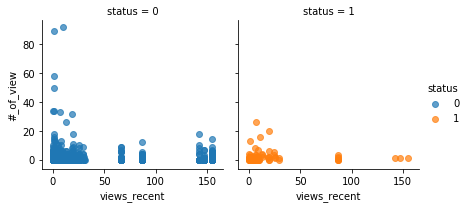

In [72]:
plot = cluster_view(df, 'views_recent', '#_of_view')

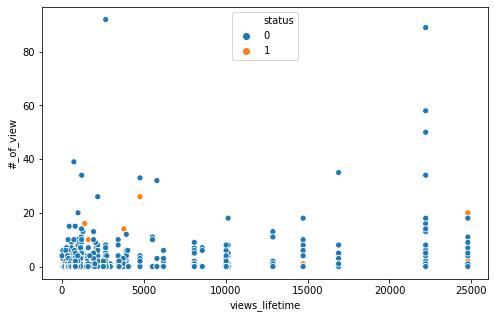

In [73]:
plot = overview(df, 'views_lifetime', '#_of_view')

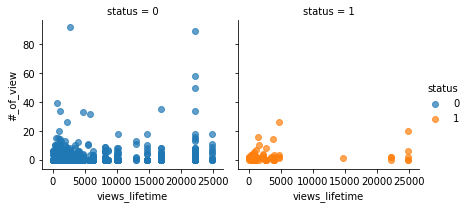

In [74]:
plot = cluster_view(df, 'views_lifetime', '#_of_view')

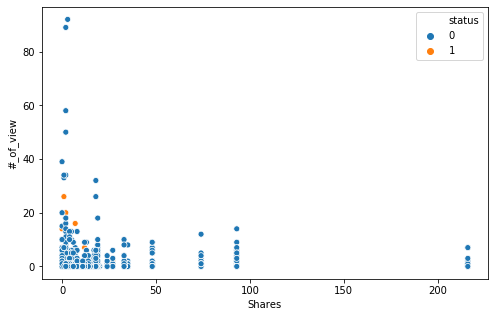

In [75]:
plot = overview(df, 'Shares', '#_of_view')

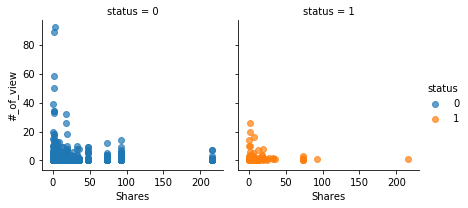

In [76]:
plot = cluster_view(df, 'Shares', '#_of_view')

<i>Find out those assets have high # of views but lost opportunity.</i>

In [77]:
insight2 = df.loc[df['#_of_view'] >= 40]
insight2

,content_name,opportunity_id,opportunity_name,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,...,Shares,Social shares,total_time_spent,#_of_view,opportunity_created_date,opportunity_close_date,added_arr_converted,#_of_stages,days_to_close,status
666,Sales Overview Video.mp4,0065700000qk0t2,Upsell - Valspar ULT +50,10.0,0.0,2674.0,1.0,9.0,48.0,4.0,...,3.0,0.0,4599.0,92,6/15/2017,2/13/2018,NaN,2,243.0,0
945,Showpad Overview Deck.pdf,0065700000thUKe,New - De Meeuw ESS +5,1.0,0.0,22208.0,3.0,5.0,41.0,3.0,...,2.0,14.0,1151.0,89,2/15/2018,11/12/2018,2415.0,4,270.0,0
952,Showpad Overview Deck.pdf,0065700000uKF0u,New - Coilcraft +30,1.0,0.0,22208.0,3.0,5.0,41.0,3.0,...,2.0,14.0,1273.0,58,6/18/2018,12/18/2018,15000.0,5,183.0,0
983,Showpad Overview Deck.pdf,0065700000w7bxZ,New - ATCO Group,1.0,0.0,22208.0,3.0,5.0,41.0,3.0,...,2.0,14.0,2180.0,50,8/20/2018,9/28/2018,NaN,2,39.0,0


- <b>Views recent/Views lifetime/Shares vs added arr converted</b>

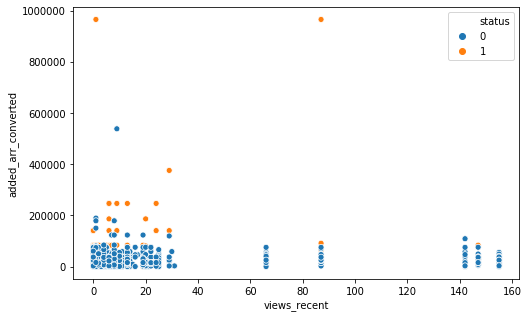

In [78]:
plot = overview(df, 'views_recent', 'added_arr_converted')

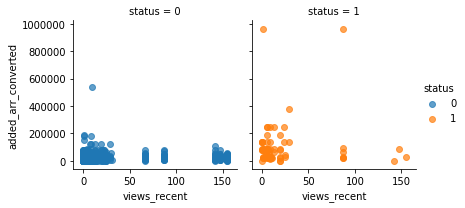

In [79]:
plot = cluster_view(df, 'views_recent', 'added_arr_converted')

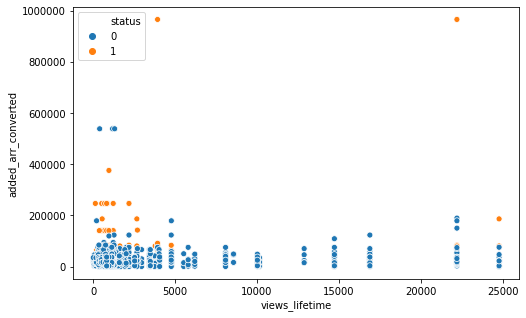

In [80]:
plot = overview(df, 'views_lifetime', 'added_arr_converted')

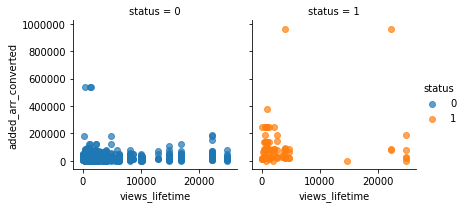

In [81]:
plot = cluster_view(df, 'views_lifetime', 'added_arr_converted')

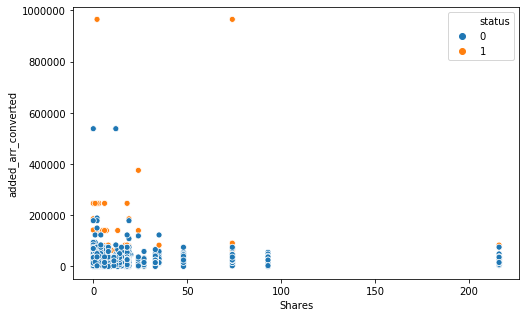

In [82]:
plot = overview(df, 'Shares', 'added_arr_converted')

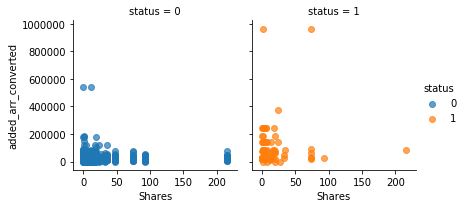

In [83]:
plot = cluster_view(df, 'Shares', 'added_arr_converted')

In [84]:
insight3 = df.loc[df['added_arr_converted'] > 800000]
insight3

,content_name,opportunity_id,opportunity_name,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,...,Shares,Social shares,total_time_spent,#_of_view,opportunity_created_date,opportunity_close_date,added_arr_converted,#_of_stages,days_to_close,status
41,Salesforce Integration One Pager.pdf,0065700000uJPS7,New - Qiagen ULT +1100,87.0,2.0,3934.0,1.0,53.0,81.0,26.0,...,74.0,4.0,0.0,0,6/6/2018,12/18/2018,965057.0,5,195.0,1
65,Showpad Overview Deck.pdf,0065700000uJPS7,New - Qiagen ULT +1100,1.0,0.0,22208.0,3.0,5.0,41.0,3.0,...,2.0,14.0,35.0,2,6/6/2018,12/18/2018,965057.0,5,195.0,1


- <b>Views recent/Views lifetime/Shares vs sales cycle length</b>

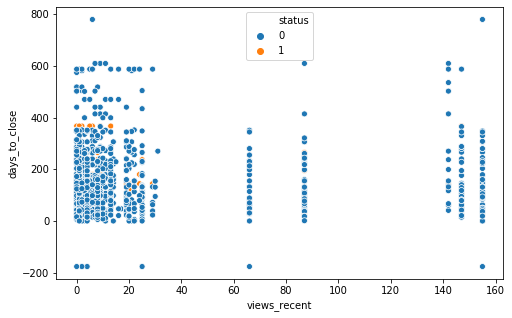

In [86]:
plot = overview(df, 'views_recent', 'days_to_close')

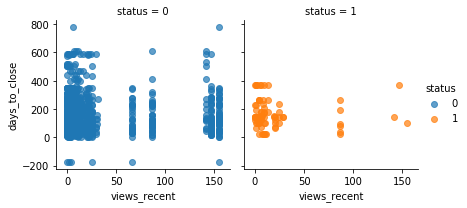

In [87]:
plot = cluster_view(df, 'views_recent', 'days_to_close')

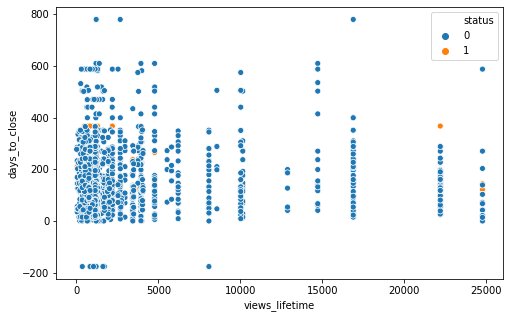

In [88]:
plot = overview(df, 'views_lifetime', 'days_to_close')

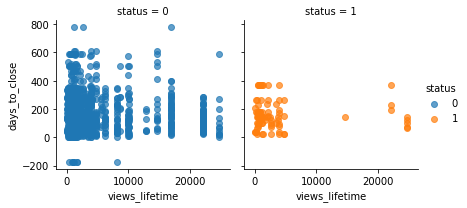

In [89]:
plot = cluster_view(df, 'views_lifetime', 'days_to_close')

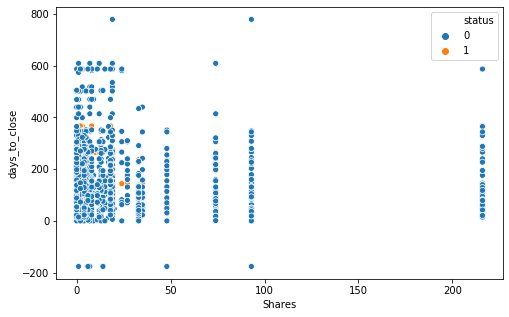

In [90]:
plot = overview(df, 'Shares', 'days_to_close')

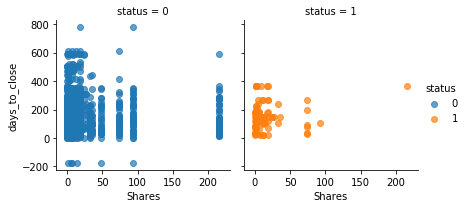

In [91]:
plot = cluster_view(df, 'Shares', 'days_to_close')

In [92]:
insight4 = df.loc[df['days_to_close'] < 0]
insight4

,content_name,opportunity_id,opportunity_name,views_recent,downloads_recent,views_lifetime,likes_lifetime,In-app number of views,In-app avg daily view duration (secs),In-app viewers,...,Shares,Social shares,total_time_spent,#_of_view,opportunity_created_date,opportunity_close_date,added_arr_converted,#_of_stages,days_to_close,status
639,Rockfon Case Study.pdf,0065700000uLg44,New - Nucor,4.0,0.0,354.0,2.0,23.0,46.0,11.0,...,7.0,6.0,0.0,0,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1115,Showpad for Construction One Pager.pdf,0065700000uLg44,New - Nucor,2.0,0.0,1061.0,0.0,15.0,144.0,6.0,...,6.0,1.0,91.0,9,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1139,Showpad for Manufacturing One Pager.pdf,0065700000uLg44,New - Nucor,25.0,1.0,1704.0,0.0,17.0,34.0,9.0,...,14.0,1.0,83.0,4,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1192,Showpad for Marketing One Pager.pdf,0065700000uLg44,New - Nucor,155.0,3.0,1200.0,4.0,54.0,79.0,21.0,...,93.0,7.0,35.0,3,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1246,Showpad for Onboarding & Coaching Deck.pdf,0065700000uLg44,New - Nucor,0.0,0.0,1613.0,0.0,6.0,27.0,5.0,...,1.0,0.0,55.0,7,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1247,Showpad for Onboarding & Coaching Solution Ove...,0065700000uLg44,New - Nucor,NaN,NaN,828.0,0.0,NaN,NaN,NaN,...,NaN,NaN,22.0,4,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1287,Showpad for Sales One Pager.pdf,0065700000uLg44,New - Nucor,66.0,3.0,8084.0,1.0,47.0,67.0,29.0,...,48.0,7.0,9.0,2,7/10/2018,1/15/2018,25000.0,3,-176.0,0
1358,Why Companies Are Investing Heavily in Sales E...,0065700000uLg44,New - Nucor,NaN,NaN,1036.0,0.0,NaN,NaN,NaN,...,NaN,NaN,458.0,2,7/10/2018,1/15/2018,25000.0,3,-176.0,0


### Modeling for opportunity status prediction

In [93]:
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors, naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [94]:
df.columns

Index(['content_name', 'opportunity_id', 'opportunity_name', 'views_recent',
       'downloads_recent', 'views_lifetime', 'likes_lifetime',
       'In-app number of views', 'In-app avg daily view duration (secs)',
       'In-app viewers', 'In-app avg view duration (secs)',
       'Recipient number of views', 'Recipient avg daily view duration (secs)',
       'Recipient viewers', 'Recipient avg view duration (secs)', 'Shares',
       'Social shares', 'total_time_spent', '#_of_view',
       'opportunity_created_date', 'opportunity_close_date',
       'added_arr_converted', '#_of_stages', 'days_to_close', 'status'],
      dtype='object')

In [95]:
x = df.drop(['content_name', 'opportunity_id', 'opportunity_name','opportunity_created_date', 
             'opportunity_close_date','status'],axis=1)
y = df['status']

- <b> Impute missing values </b>

In [96]:
x.isnull().any()

views_recent                                 True
downloads_recent                             True
views_lifetime                               True
likes_lifetime                               True
In-app number of views                       True
In-app avg daily view duration (secs)        True
In-app viewers                               True
In-app avg view duration (secs)              True
Recipient number of views                    True
Recipient avg daily view duration (secs)     True
Recipient viewers                            True
Recipient avg view duration (secs)           True
Shares                                       True
Social shares                                True
total_time_spent                            False
#_of_view                                   False
added_arr_converted                          True
#_of_stages                                 False
days_to_close                               False
dtype: bool

In [97]:
def impute(data, variable):
    # Fill in missing value with most frequent value 
    tmp = np.array([data[variable]]).T

    imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    new_var = imp_freq.fit_transform(tmp)

    new_var = pd.DataFrame(new_var)

    return new_var

In [98]:
impute_list = ['views_recent', 'downloads_recent', 'views_lifetime', 'likes_lifetime', 'In-app number of views',
               'In-app avg daily view duration (secs)', 'In-app viewers', 'In-app avg view duration (secs)',
               'Recipient number of views', 'Recipient avg daily view duration (secs)', 'Recipient viewers',
               'Recipient avg view duration (secs)', 'Shares', 'Social shares', 'added_arr_converted']

x_imp = x.copy()

for i in range(len(impute_list)):
    x_imp[impute_list[i]] = impute(x, impute_list[i])

- <b> Create train and test set split at 67/33 </b>

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x_imp, y, test_size=0.33, random_state=11)

print('x_train shape is: ', x_train.shape, 'y_train shape is: ', y_train.shape)
print('x_test shape is: ', x_test.shape, 'y_test shape is: ', y_test.shape)

x_train shape is:  (966, 19) y_train shape is:  (966,)
x_test shape is:  (477, 19) y_test shape is:  (477,)


- <b> Normalize indepedent vars </b>

In [100]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_norm = min_max_scaler.fit_transform(x_train)
x_test_norm = min_max_scaler.fit_transform(x_test)

- <b> Format vars for modeling </b>

In [101]:
X_train = np.array(x_train_norm)
X_test = np.array(x_test_norm)

Y_train = np.array(y_train)
Y_test = np.array(y_test)

- Model 1 using default settings<br>
This method is using L2 penalty (aka Ridge by adding “squared magnitude” of coefficient as penalty term to the loss function).<br>
- Model 2 using L1 penalty<br>
This method is using L1 penalty (aka LASSO by adding “absolute value of magnitude” of coefficient as penalty term to the loss function).<br>
- Model 3 using random forest 'gini' as measurement<br>
- Model 4 using naive bayes<br>
- Model 5 using k-nearest neighbor<br>
- Model 6 using linear discriminant analysis<br>
- Model 7 using neural network default<br>
- Model 8 using neural network logistic activation<br>
- Model 9 using neural network tanh activation<br>
- Model 10 using neural network sgd solver constant learning rate<br>
- Model 11 using neural network sgd solver invscaling learning rate<br>
- Model 12 using neural network sgd solver adaptive learning rate<br>

In [102]:
logReg1 = LogisticRegression(solver='lbfgs')
logReg2 = LogisticRegression(penalty='l1', solver='saga')
rfclf1 = RandomForestClassifier(min_samples_split=3)
nbclf = naive_bayes.GaussianNB()
knnclf = neighbors.KNeighborsClassifier(n_neighbors = 5, weights='distance')
ldclf = LinearDiscriminantAnalysis()
nnclf = MLPClassifier()
nnclf1 = MLPClassifier(activation='logistic')
nnclf2 = MLPClassifier(activation='tanh')
nnclf3 = MLPClassifier(solver='sgd')
nnclf4 = MLPClassifier(solver='sgd', learning_rate='invscaling')
nnclf5 = MLPClassifier(solver='sgd', learning_rate='adaptive')

algorithms = [logReg1, logReg2, rfclf1, nbclf, knnclf, ldclf, nnclf, nnclf1, nnclf2, nnclf3, nnclf4, nnclf5]

In [103]:
def modeling(algo):
    algo = algo.fit(X_train, Y_train)
    predictions = algo.predict(X_test)

    # Use score method to get accuracy of model
    score = algo.score(X_test, Y_test)
    print('Accuracy of {} is {:.4f}'.format(algo, score))

    cm = metrics.confusion_matrix(Y_test, predictions, labels=[1,0])
    print(cm)

    print(classification_report(Y_test, predictions))
    
    return score

In [104]:
acc = []
for i in range (len(algorithms)):
    acc.append(modeling(algorithms[i]))

Accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) is 0.9476
[[  5  25]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       447
           1       1.00      0.17      0.29        30

    accuracy                           0.95       477
   macro avg       0.97      0.58      0.63       477
weighted avg       0.95      0.95      0.93       477

Accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
  

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False) is 0.9560
[[ 13  17]
 [  4 443]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       447
           1       0.76      0.43      0.55        30

    accuracy                           0.96       477
   macro avg       0.86      0.71      0.77       477
weighted avg       0.95      0.96      0.95       477



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False) is 0.9371
[[  0  30]
 [  0 447]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       447
           1       0.00      0.00      0.00        30

    accuracy                           0.94       477
   macro avg       0.47      0.50      0.48       477
weighted avg       0.88      0.94      0.91       477

Accuracy of MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_sto

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='invscaling',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False) is 0.9350
[[  4  26]
 [  5 442]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       447
           1       0.44      0.13      0.21        30

    accuracy                           0.94       477
   macro avg       0.69      0.56      0.59       477
weighted avg       0.91      0.94      0.92       477

Accuracy of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stoppi

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
print(acc)

[0.9475890985324947, 0.949685534591195, 0.9685534591194969, 0.9308176100628931, 0.949685534591195, 0.9580712788259959, 0.9559748427672956, 0.9371069182389937, 0.9559748427672956, 0.9371069182389937, 0.9350104821802935, 0.9371069182389937]


Text(0.5, 257.44, 'Predicted label')

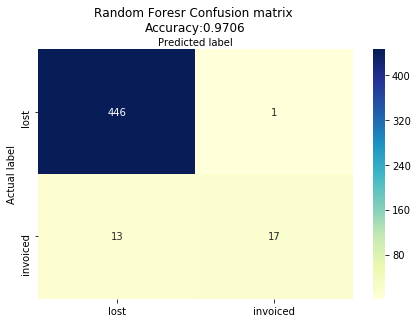

In [130]:
model = rfclf1.fit(X_train, Y_train)
predictions = rfclf1.predict(X_test)
score = rfclf1.score(X_test, Y_test)
cm = metrics.confusion_matrix(Y_test, predictions)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cm_df = pd.DataFrame(cm,
                     index = ['lost', 'invoiced'], 
                     columns = ['lost', 'invoiced'])

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cm_df), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Random Foresr Confusion matrix \nAccuracy:{0:.4f}'.format(score), y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

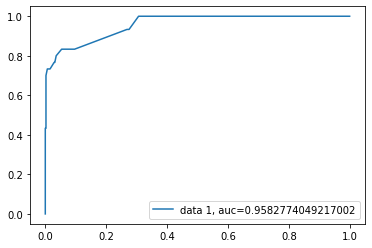

In [131]:
y_pred_proba = rfclf1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [132]:
print (rfclf1.feature_importances_)

[0.01139637 0.00826435 0.03371939 0.01243424 0.01598735 0.02223123
 0.02393889 0.01547354 0.01729709 0.01065396 0.01196641 0.01545453
 0.01312301 0.01609486 0.06731746 0.03359995 0.32156252 0.2768228
 0.07266206]


In [133]:
'''## Probalility of getting 1 i.e invoiced
prob_test_1 = rfclf1.predict_proba(X_test)[:,1]
#prob_test_1

prob_train_1 = rfclf1.predict_proba(X_train)[:,1]
#prob_train_1
'''

'## Probalility of getting 1 i.e invoiced\nprob_test_1 = rfclf1.predict_proba(X_test)[:,1]\n#prob_test_1\n\nprob_train_1 = rfclf1.predict_proba(X_train)[:,1]\n#prob_train_1\n'

### Validation

In [134]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, x_imp, y, cv=10)
cv_scores
print("Overall Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Overall Accuracy: 0.95 (+/- 0.07)
